In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg    
from imgaug import augmenters as iaa


# Dat preparation

In [3]:
datadir = "Data_Collect"
columns = ["center", "left", "right", "steering", "throttle",
"reverse", "speed"]

#data = pd.read_csv(os.path.join(datadir, "driving_log.csv"), names = columns)
data = pd.read_csv(os.path.join(datadir, "driving_log.csv"), names = columns)
pd.set_option("display.max_colwidth", -1)

#data.head()


/var/folders/wj/2bdfjxmx6_dd5gvnsyg6_rvc0000gn/T/ipykernel_1526/4251334168.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_07_15_22_09_30_700.jpg,left_2022_07_15_22_09_30_700.jpg,right_2022_07_15_22_09_30_700.jpg,0.0,0.0,0,0.000082
1,center_2022_07_15_22_09_30_800.jpg,left_2022_07_15_22_09_30_800.jpg,right_2022_07_15_22_09_30_800.jpg,0.0,0.0,0,0.000084
2,center_2022_07_15_22_09_30_908.jpg,left_2022_07_15_22_09_30_908.jpg,right_2022_07_15_22_09_30_908.jpg,0.0,0.0,0,0.000078
3,center_2022_07_15_22_09_31_020.jpg,left_2022_07_15_22_09_31_020.jpg,right_2022_07_15_22_09_31_020.jpg,0.0,0.0,0,0.000080
4,center_2022_07_15_22_09_31_122.jpg,left_2022_07_15_22_09_31_122.jpg,right_2022_07_15_22_09_31_122.jpg,0.0,0.0,0,0.000079


## 1) Steering angle visualization
### We can see that most of the data have steering angle data = 0

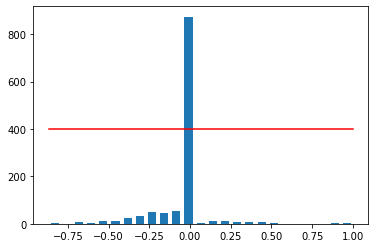

In [5]:
num_bins = 25
samples_per_bin = 400

hist, bins = np.histogram(data["steering"], num_bins)

center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data["steering"]), np.max(data["steering"])), (samples_per_bin, samples_per_bin), color = "red")

### Reduce every bin to only have 400 data. After reduce the number of data, we can see that each bin have max 400 data points

total data: 1179
removed: 474
remaining: 705


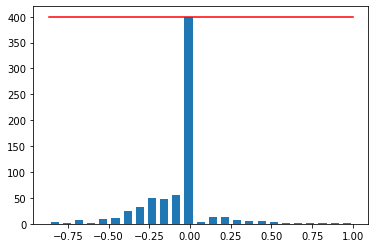

In [6]:
#for j in range(num_bins):
#    print(bins[j])
#print("--------")


from turtle import color


print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    #print(bins[j])
    list_ = []
    for i in range(len(data['steering'])):
        # Check each bins only have 400 data 
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:

            #print(data['steering'][i])
            list_.append(i)
    list_ = shuffle(list_)
    #set the number of data in bins to 400
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
# Remove the data with steering angle = 0 to max number 400
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin), color = "red")

## 2) Extract the image's path and the corresponding steering angle information

In [7]:
print(data.iloc[1])
print("----------")
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)
#print(image_paths)

center      center_2022_07_15_22_09_30_908.jpg
left        left_2022_07_15_22_09_30_908.jpg  
right       right_2022_07_15_22_09_30_908.jpg 
steering    0.0                               
throttle    0.0                               
reverse     0                                 
speed       0.000078                          
Name: 2, dtype: object
----------


## 3) Split the data using the sklearn library

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

print("Training samples", len(X_train))
print('Valid samples', len(X_valid))

Training samples 1692
Valid samples 423


### Check the distribution of the training and test dataset

Text(0.5, 1.0, 'Validation set')

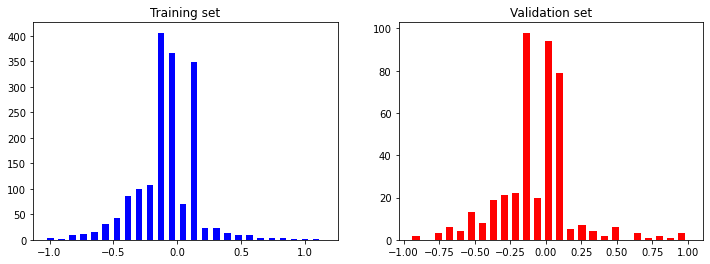

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
axes[0].hist(y_train, bins = num_bins, width = 0.05, color = "blue")
axes[0].set_title("Training set")

axes[1].hist(y_valid, bins = num_bins, width = 0.05, color = "red")
axes[1].set_title("Validation set")

## 4) Explore and clean the data. 
### Applied various computer vision filtering echniques to it.

### 4.1) Zooming in on the images

In [10]:
def zoom(image):
    #Affine transformations involve Scaling (“zoom” in/out)
    zoom = iaa.Affine(scale = (1, 1.3))
    image = zoom.augment_image(image)
    return image

Text(0.5, 1.0, 'Zoomed Image')

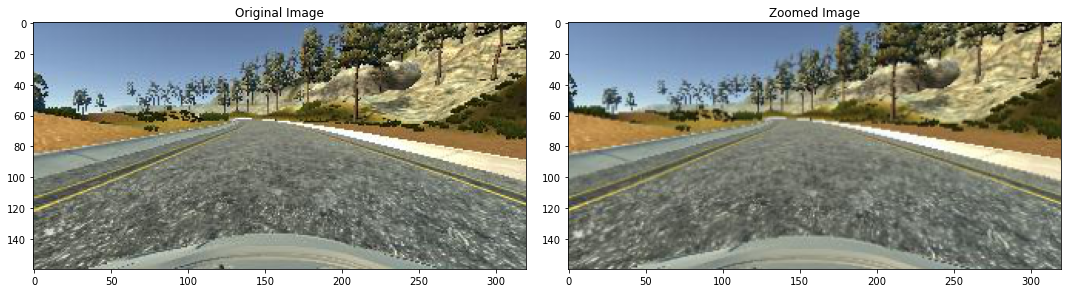

In [11]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize =(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Original Image")

axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed Image")

### 4.2) Pan the images

In [12]:
def pan(image):
    #Translation (“move” image on the x-/y-axis)
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

Text(0.5, 1.0, 'Panned Image')

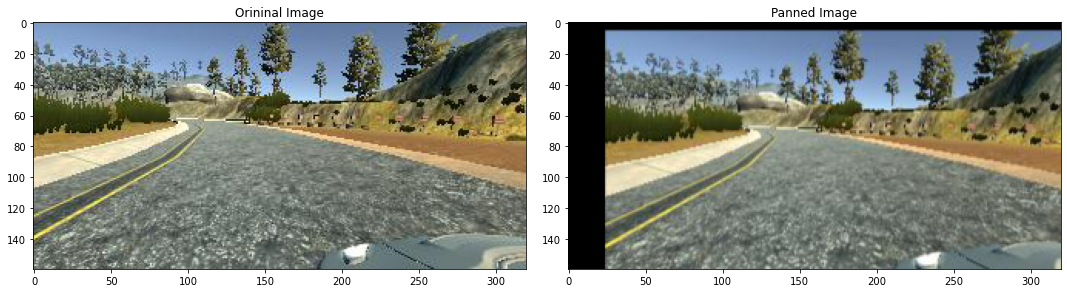

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Orininal Image")

axs[1].imshow(panned_image)
axs[1].set_title("Panned Image")

### 4.3) Adjust the brightness of the images

In [14]:
def img_random_brightness(image):
    brigthness = iaa.Multiply((0.2, 1.2))
    image = brigthness.augment_image(image)
    return image

Text(0.5, 1.0, 'brightness adjust Image')

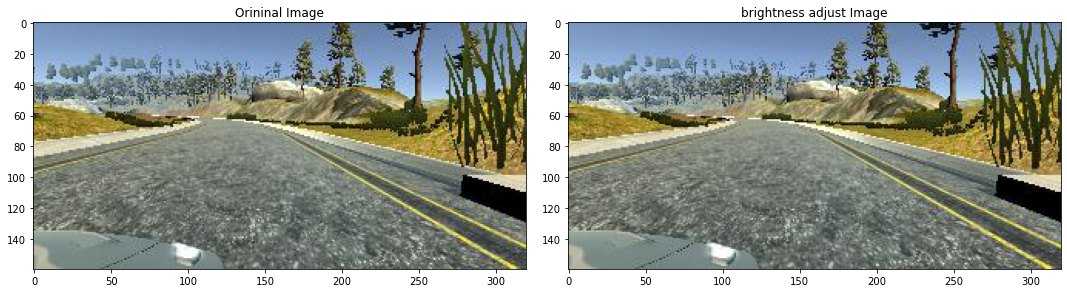

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
bright_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Orininal Image")

axs[1].imshow(bright_image)
axs[1].set_title("brightness adjust Image")

### 4.4) Flip the images horizontally and vertically

In [16]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle

166


Text(0.5, 1.0, 'brightness adjust Image')

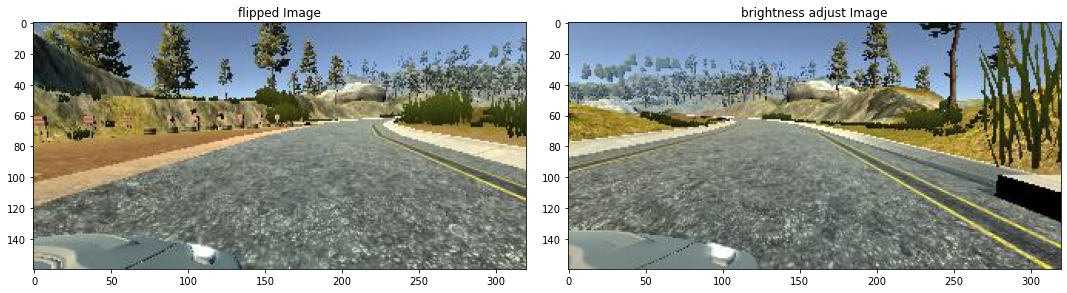

In [17]:
random_index = random.randint(0, 1000)
print(random_index)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle = steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(flipped_image)
axs[0].set_title("flipped Image")

axs[1].imshow(bright_image)
axs[1].set_title("brightness adjust Image")

## 5) Randomly applied filter on images

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

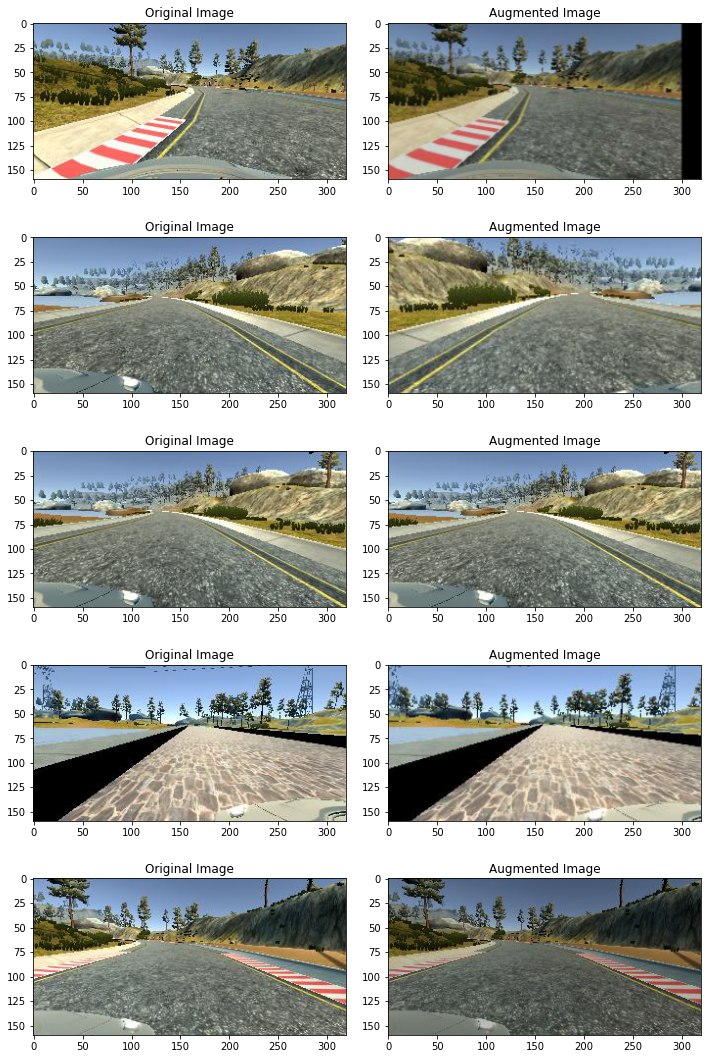

In [19]:
ncol = 2
nrow = 5

fig, axs = plt.subplots(nrow, ncol, figsize = (10, 15))
fig.tight_layout()

for i in range(5):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)


    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

## 6) Cropping the image and applying Gaussian blur

In [20]:
#applied Gaussian blur
def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

Text(0.5, 1.0, 'pre_process Image')

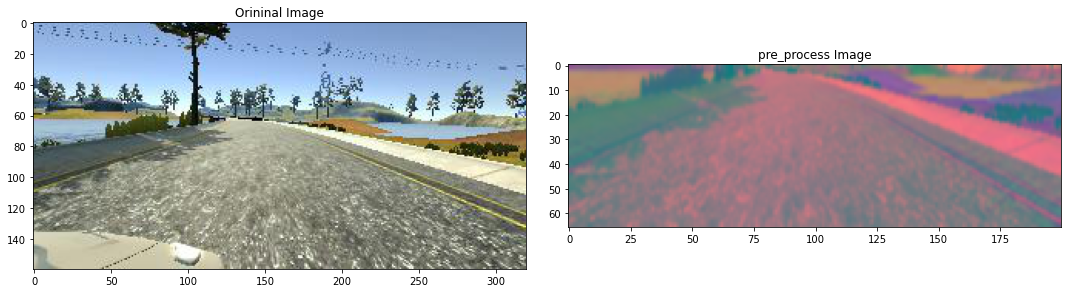

In [21]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
pre_process_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title("Orininal Image")

axs[1].imshow(pre_process_image)
axs[1].set_title("pre_process Image")

In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        # : Create empty list for batch_img and batch_streeing for each batch processing  
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            # : size-shaped array of random integers from the appropriate distribution, or a single such random int if size not provided.
            random_index = random.randint(0, len(image_paths) - 1)
            # : Check batch-generator is training or testing. 
            # : If it is training it performs random_aumentation method  and get the img and steering angle
            # : else it reads the image paths with random index to get the image  and steering angle
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            # : Perform Image processing techniques for converting a image to YUV color, removing blur and resize the image
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

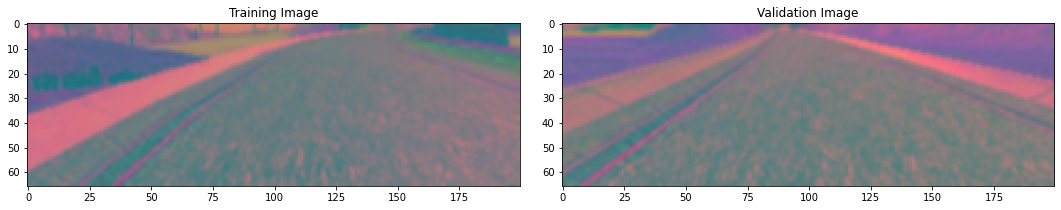

In [23]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

# Model development
## Model architercture provided by NVIDIA

In [24]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Convolution2D(64, (3, 3), activation='elu'))

    model.add(Convolution2D(64, 3, 3, activation='elu'))
    #   model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(50, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(10, activation = 'elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [25]:
model = nvidia_model()
print(model.summary())

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 6, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                         

2022-07-16 13:47:14.445649: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-16 13:47:14.445976: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/changyuyuan/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
from numpy import matrix
from sklearn import metrics

history = model.fit(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle = 1,
                              )

Epoch 1/10


2022-07-16 13:47:14.846431: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-16 13:47:15.115008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - ETA: 0s - loss: 0.0743

2022-07-16 13:47:58.457519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


300/300 [==============================] - 59s 194ms/step - loss: 0.0743 - val_loss: 0.0556
Epoch 2/10
300/300 [==============================] - 56s 188ms/step - loss: 0.0473 - val_loss: 0.0549
Epoch 3/10
300/300 [==============================] - 56s 188ms/step - loss: 0.0467 - val_loss: 0.0535
Epoch 4/10
300/300 [==============================] - 56s 188ms/step - loss: 0.0455 - val_loss: 0.0513
Epoch 5/10
300/300 [==============================] - 57s 189ms/step - loss: 0.0445 - val_loss: 0.0454
Epoch 6/10
300/300 [==============================] - 57s 189ms/step - loss: 0.0418 - val_loss: 0.0429
Epoch 7/10
300/300 [==============================] - 57s 189ms/step - loss: 0.0403 - val_loss: 0.0406
Epoch 8/10
300/300 [==============================] - 56s 189ms/step - loss: 0.0393 - val_loss: 0.0388
Epoch 9/10
300/300 [==============================] - 57s 190ms/step - loss: 0.0371 - val_loss: 0.0394
Epoch 10/10
300/300 [==============================] - 57s 191ms/step - loss: 0.0368

In [27]:
model.save("SDC Chp10.h5")

# Check the model's training and validation loss

Text(0.5, 0, 'Epoch')

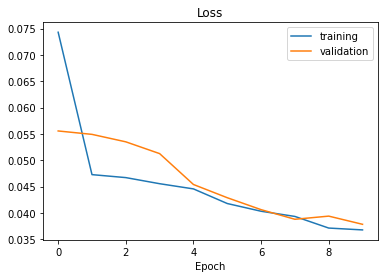

In [28]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("Epoch")

# Run the model in the stimulator

In [29]:
import socketio
import eventlet
from flask import Flask
from keras.models import load_model
import base64
from io import BytesIO
from PIL import Image
import cv2



In [30]:
sio = socketio.Server()
print(sio)

app = Flask(__name__) #'__main__'
print(app)
speed_limit = 10
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

<Flask '__main__'>


In [31]:
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    send_control(0, 0)
 
def send_control(steering_angle, throttle):
    sio.emit('steer', data = {
        'steering_angle': steering_angle.__str__(),
        'throttle': throttle.__str__()
    })

In [32]:
@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = img_preprocess(image)
    image = np.array([image])
    steering_angle = float(model.predict(image))
    throttle = 1.0 - speed/speed_limit
    print('{} {} {}'.format(steering_angle, throttle, speed))
    send_control(steering_angle, throttle)

In [33]:
if __name__ == '__main__':
    model = load_model("SDC Chp10.h5")
    print(model)
    app = socketio.Middleware(sio, app)
    print("in")
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

in


(1526) wsgi starting up on http://0.0.0.0:4567
wsgi exiting
(1526) wsgi exited, is_accepting=True
